In [1]:
import os
import re
import h5py
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def DeltaR(eta1,phi1, eta2,phi2):
    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

def FourMomentum(pt, eta, phi, m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return e, px, py, pz

def PtEtaPhiM(px, py, pz, e):
    E, px, py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(np.sqrt((E**2 - px**2 - py**2 - pz**2)**2))

    return pt, eta, phi, m

def InvM(e, px, py, pz):
    return np.sqrt(e**2 - px**2 - py**2 - pz**2)

In [3]:
def get_info(path):
    # path: run path
    name = os.path.split(path)[1]

    with open(os.path.join(path, f'{name}_tag_1_banner.txt')) as f:
        for line in f.readlines():
            match = re.match(' +10 (-?.*?) # khhh', line)
            if match:
                kappa = float(match.group(1))
                
            #  Integrated weight (pb)  :       0.020257
            match = re.match('#  Integrated weight \(pb\)  : +(\d+\.\d+)', line)
            if match:
                # unit: fb
                cross_section = float(match.group(1)) * 1000
            
            #  Number of Events        :       100000
            match = re.match('#  Number of Events        : +(\d+)', line)
            if match:
                nevent = int(match.group(1))
    
    return kappa, cross_section, nevent

In [4]:
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest  

In [5]:
def compare_jet_list_diHiggs(pair1, pair2, nh_max=2):
    # 返回配對是否完全相同，有幾個 Higgs 相同
    h1_true = {pair1[0],pair1[1]}
    h2_true = {pair1[2],pair1[3]}
    
    h1_test = {pair2[0],pair2[1]}
    h2_test = {pair2[2],pair2[3]}
    
    test_h = [h1_test, h2_test]
    
    nh = 0
    for id1, id2 in itertools.permutations([0,1]):
        h1 = test_h[id1]
        h2 = test_h[id2]
        if h1_true == h1:
            nh = 1
            if h2_true == h2:
                nh = 2         
                
    same = True if nh==nh_max else False
    return same, nh

In [6]:
def deltaR_condition(R1, R2, m4j):
    # R1: Delta R of leading Higgs candidate
    # R2: Delta R of sub-leading Higgs candidate
    
    if m4j < 1250:
        if R1 > 653 / m4j + 0.475:
            return False
        if R1 < 360 / m4j - 0.5:
            return False

        if R2 > 875 / m4j + 0.35:
            return False
        if R2 < 235 / m4j:
            return False      
    else:
        if R1 > 1:
            return False
        if R1 < 0:
            return False

        if R2 > 1:
            return False
        if R2 < 0:
            return False
    return True

def DHH(m1, m2):
    # m1: mass of leading Higgs candidate
    # m2: mass of sub-leading Higgs candidate
    
    return abs(m1 - 120/110*m2) / (1 + (120/110)**2)**0.5

def DHH_dR_method(PT, Eta, Phi, Mass):
    # get the pairing by DeltaR method
    # 已經過 preseleciton PT, Eta, Phi, Mass都只有4個jets的資料
    
    # Total invariant mass of 4 b-jets
    e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
    m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))
    
    pairing = []
    for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):
        PT1 = PT[[i1,i2]]
        PT2 = PT[[i3,i4]]
        # sorted by PT scalar sum
        if np.sum(PT1) < np.sum(PT2):
            i1, i2, i3, i4 = i3, i4, i1, i2

        PT1 = PT[[i1,i2]] 
        Eta1 = Eta[[i1,i2]]
        Phi1 = Phi[[i1,i2]]
        Mass1 = Mass[[i1,i2]]

        e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
        mH1 = InvM(np.sum(e1), np.sum(px1), np.sum(py1), np.sum(pz1))

        PT2 = PT[[i3,i4]]
        Eta2 = Eta[[i3,i4]]
        Phi2 = Phi[[i3,i4]]
        Mass2 = Mass[[i3,i4]]

        e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
        mH2 = InvM(np.sum(e2), np.sum(px2), np.sum(py2), np.sum(pz2))

        dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
        dR2 = DeltaR(Eta2[0], Phi2[0], Eta2[1], Phi2[1])

        if deltaR_condition(dR1, dR2, m4j):
            d = DHH(mH1, mH2)
            pairing.append([i1,i2,i3,i4, d])
    
    if len(pairing) == 0:
        return pairing
    
    # choose the pairing with minimum DHH
    h_candidate = pairing[0][0:4]
    min_DHH = pairing[0][4]
    for i1,i2,i3,i4, d in pairing:
        if d < min_DHH:
            min_DHH = d
            h_candidate = [i1,i2,i3,i4]

    return h_candidate

def min_dR_method(PT, Eta, Phi, Mass):
    # get h-jets pairing
    # 已經過 preseleciton PT, Eta, Phi, Mass都只有4個jets的資料
    # 配對結果由0123表示，0123代表第幾個jet
    pairing = []
    for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):

        PT1 = PT[[i1,i2]] 
        Eta1 = Eta[[i1,i2]]
        Phi1 = Phi[[i1,i2]]
        Mass1 = Mass[[i1,i2]]
        
        e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
        PTH1, EtaH1, PhiH1, _ = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

        PT2 = PT[[i3,i4]]
        Eta2 = Eta[[i3,i4]]
        Phi2 = Phi[[i3,i4]]
        Mass2 = Mass[[i3,i4]]

        e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
        PTH2, EtaH2, PhiH2, _ = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))
        
        # sorted by PT vector sum
        if PTH1 < PTH2:
            i1, i2, i3, i4 = i3, i4, i1, i2
            PTH1, EtaH1, PhiH1, PTH2, EtaH2, PhiH2 = PTH2, EtaH2, PhiH2, PTH1, EtaH1, PhiH1

        dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
        pairing.append([i1,i2,i3,i4, dR1])
    
    h_candidate = pairing[0][0:4]
    min_dR = pairing[0][4]
    for i1,i2,i3,i4, dR in pairing:
        if dR < min_dR:
            min_dR = dR
            h_candidate = [i1,i2,i3,i4]
            
    return h_candidate

In [7]:
def diHiggs_pairing_performance_HDF5(file_path, mass, pairing_method, xection=None, title='', nevent_max=1000):
    # input file has jet matching data (未通過 SPANET)
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        match_count = 0
        
        correct_selection_count = 0
        wrong_selection_count = 0
        correct_pair_count = 0
        wrong_pair_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)

        for event in tqdm(range(nevent)):

            nj = f['source/mask'][event].sum()
            jet_PT = f['source/pt'][event][:nj]
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = f['source/mass'][event][:nj]
            jet_BTag = f['source/btag'][event][:nj]
            
            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4:
                continue
            Eta_PT_BTag_count += 1
            
            if not(f['h1/mask'][event] and f['h2/mask'][event]):
                continue
            match_count += 1
            
            # correct jet pairing
            correct_pair = [f['h1/b1'][event], f['h1/b2'][event], 
                            f['h2/b1'][event], f['h2/b2'][event],]
            
            # choose 4 highest pt b-jets
            h_jets = eta_pt_bTag_cut[0:4]
            
            correct_selection = True
            for j in correct_pair:
                if j not in h_jets:
                    correct_selection = False
                    break
                    
            if not correct_selection:
                wrong_selection_count += 1
                continue
            correct_selection_count += 1
            
            # PT Eta Phi Mass for preselection jets
            PT = jet_PT[h_jets]
            Eta = jet_Eta[h_jets]
            Phi = jet_Phi[h_jets]
            Mass = jet_Mass[h_jets]
            
            if pairing_method == 'min-dR':
                h_pair = min_dR_method(PT, Eta, Phi, Mass)
            elif pairing_method == 'DHH-dR':
                h_pair = DHH_dR_method(PT, Eta, Phi, Mass)
            else:
                print('Wrong pairing method')
        
            if len(h_pair) == 0:
                wrong_pair_count += 1
                continue
                    
            same, _ = compare_jet_list_diHiggs(correct_pair, h_jets[h_pair])
            
            if same:
                correct_pair_count += 1
            else:
                wrong_pair_count += 1
   
        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

        print('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', Eta_PT_BTag_count, cross_section * Eta_PT_BTag_count / nevent)

        result = {
            'Mass': mass,
            'nevent': nevent,
            'Matching': match_count,
            'correct selection': correct_selection_count,
            'correct pair': correct_pair_count,
            'wrong pair': wrong_pair_count,
        }
        print(f'Total number of event with true pairing: {match_count}')
        print(f'Correct selection: {correct_selection_count} {correct_selection_count/match_count}')
        print(f'Correct pairing: {correct_pair_count} {correct_pair_count/correct_selection_count}')
        print(f'Pairing efficiency: {correct_pair_count} {correct_pair_count/match_count}')
        return result

In [8]:
def diHiggs_SPANET_pairing_performance(truth_file, predict_file, xection=None, title='', nevent_max=1000):
    # truth file 未通過 SPANET，predict file 已通過 SPANET，
    
    with h5py.File(predict_file, 'r') as f, h5py.File(truth_file, 'r') as f_true:
        Eta_PT_BTag_count = 0
        match_count = 0
        
        correct_selection_count = 0
        wrong_selection_count = 0
        correct_pair_count = 0
        wrong_pair_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)

        for event in tqdm(range(nevent)):

            nj = f['source/mask'][event].sum()
            jet_PT = np.exp(f['source/pt'][event][:nj])
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = np.exp(f['source/mass'][event][:nj])
            jet_BTag = f['source/btag'][event][:nj]
            
            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4:
                continue
            Eta_PT_BTag_count += 1
            
            if not(f_true['h1/mask'][event] and f_true['h2/mask'][event]):
                continue
            match_count += 1
            
            # correct jet pairing
            correct_pair = [f_true['h1/b1'][event], f_true['h1/b2'][event], 
                            f_true['h2/b1'][event], f_true['h2/b2'][event],]
            
            # SPANET pairing results
            h_jets = [f['h1/b1'][event], f['h1/b2'][event], 
                      f['h2/b1'][event], f['h2/b2'][event],]
            
            correct_selection = True
            for j in correct_pair:
                if j not in h_jets:
                    correct_selection = False
                    break
                    
            if not correct_selection:
                wrong_selection_count += 1
                continue
            correct_selection_count += 1
                    
            same, _ = compare_jet_list_diHiggs(correct_pair, h_jets)
            
            if same:
                correct_pair_count += 1
            else:
                wrong_pair_count += 1
   
        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

        print('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', Eta_PT_BTag_count, cross_section * Eta_PT_BTag_count / nevent)

        result = {
            'nevent': nevent,
            'Matching': match_count,
            'correct selection': correct_selection_count,
            'correct pair': correct_pair_count,
            'wrong pair': wrong_pair_count,
        }
        print(f'Total number of event with true pairing: {match_count}')
        print(f'Correct selection: {correct_selection_count} {correct_selection_count/match_count}')
        print(f'Correct pairing: {correct_pair_count} {correct_pair_count/correct_selection_count}')
        print(f'Pairing efficiency: {correct_pair_count} {correct_pair_count/match_count}')
        return result

# Scan $\kappa_\lambda$

In [9]:
# Scan kappa
kappas, min_dR_pairings, SPANET_pairings = [], [], []

for i in range(6,32,1):
    pairing_method = 'min-dR'
    
    sample_dir = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/'
    info = get_info(os.path.join(sample_dir, f'run_{i:02}'))
    print(info)
    kappas.append(info[0])
    xection = info[1] * 0.582 * 0.582
    tot_event = info[2]

    # calculate pairing performace
    file_path = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40.h5')
    results = diHiggs_pairing_performance_HDF5(file_path, 
                                                  None,
                                                  pairing_method, 
                                                  xection, 
                                                  title='pp->hh', 
                                                  nevent_max=100000)
    min_dR_pairings.append(results)
    
    truth_file = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40.h5')
    predict_file = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict.h5')

    results = diHiggs_SPANET_pairing_performance(truth_file,
                                                  predict_file,
                                                  xection, 
                                                  title='pp->hh', 
                                                  nevent_max=100000)
    SPANET_pairings.append(results)

(-10.0, 865.4300000000001, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5628/5628 [00:17<00:00, 329.61it/s]


pp->hh
In 5628 events
Cross section: 293.14191131999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5628 293.14191131999996
Total number of event with true pairing: 4288
Correct selection: 3839 0.8952891791044776
Correct pairing: 2665 0.6941911956238603
Pairing efficiency: 2665 0.6215018656716418


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5628/5628 [00:15<00:00, 368.96it/s]


pp->hh
In 5628 events
Cross section: 293.14191131999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5628 293.14191131999996
Total number of event with true pairing: 4288
Correct selection: 3642 0.8493470149253731
Correct pairing: 2712 0.7446457990115322
Pairing efficiency: 2712 0.6324626865671642
(-9.0, 734.02, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5698/5698 [00:17<00:00, 322.93it/s]


pp->hh
In 5698 events
Cross section: 248.63019047999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5698 248.63019047999998
Total number of event with true pairing: 4348
Correct selection: 3908 0.8988040478380864
Correct pairing: 2730 0.6985670419651996
Pairing efficiency: 2730 0.6278748850045999


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5698/5698 [00:15<00:00, 363.41it/s]


pp->hh
In 5698 events
Cross section: 248.63019047999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5698 248.63019047999998
Total number of event with true pairing: 4348
Correct selection: 3654 0.8403863845446182
Correct pairing: 2717 0.7435686918445539
Pairing efficiency: 2717 0.624885004599816
(-8.0, 612.39, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5658/5658 [00:17<00:00, 326.05it/s]


pp->hh
In 5658 events
Cross section: 207.43119036 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5658 207.43119036
Total number of event with true pairing: 4310
Correct selection: 3876 0.8993039443155453
Correct pairing: 2652 0.6842105263157895
Pairing efficiency: 2652 0.6153132250580047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5658/5658 [00:15<00:00, 374.32it/s]


pp->hh
In 5658 events
Cross section: 207.43119036 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5658 207.43119036
Total number of event with true pairing: 4310
Correct selection: 3615 0.8387470997679815
Correct pairing: 2629 0.7272475795297372
Pairing efficiency: 2629 0.6099767981438515
(-7.0, 502.6, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5699/5699 [00:17<00:00, 324.72it/s]


pp->hh
In 5699 events
Cross section: 170.24268239999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5699 170.24268239999998
Total number of event with true pairing: 4374
Correct selection: 3952 0.9035208047553727
Correct pairing: 2781 0.7036943319838057
Pairing efficiency: 2781 0.6358024691358025


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5699/5699 [00:15<00:00, 376.18it/s]


pp->hh
In 5699 events
Cross section: 170.24268239999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5699 170.24268239999998
Total number of event with true pairing: 4374
Correct selection: 3708 0.8477366255144033
Correct pairing: 2797 0.7543149946062567
Pairing efficiency: 2797 0.6394604481024234
(-6.0, 403.62, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5878/5878 [00:18<00:00, 319.14it/s]


pp->hh
In 5878 events
Cross section: 136.71578087999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5878 136.71578087999998
Total number of event with true pairing: 4482
Correct selection: 4054 0.9045069165551093
Correct pairing: 2897 0.714602861371485
Pairing efficiency: 2897 0.6463632307005801


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5878/5878 [00:15<00:00, 367.46it/s]


pp->hh
In 5878 events
Cross section: 136.71578087999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5878 136.71578087999998
Total number of event with true pairing: 4482
Correct selection: 3823 0.8529674252565819
Correct pairing: 2935 0.7677216845409365
Pairing efficiency: 2935 0.6548415885765283
(-5.0, 316.29, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5905/5905 [00:18<00:00, 324.58it/s]


pp->hh
In 5905 events
Cross section: 107.13501396 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5905 107.13501396000001
Total number of event with true pairing: 4503
Correct selection: 4033 0.895625138796358
Correct pairing: 2901 0.7193156459211505
Pairing efficiency: 2901 0.6442371752165224


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5905/5905 [00:15<00:00, 378.65it/s]


pp->hh
In 5905 events
Cross section: 107.13501396 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5905 107.13501396000001
Total number of event with true pairing: 4503
Correct selection: 3831 0.8507661558960693
Correct pairing: 2943 0.7682067345340642
Pairing efficiency: 2943 0.653564290473018
(-4.0, 239.21, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6047/6047 [00:18<00:00, 326.67it/s]


pp->hh
In 6047 events
Cross section: 81.02616803999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6047 81.02616803999999
Total number of event with true pairing: 4592
Correct selection: 4141 0.9017857142857143
Correct pairing: 3065 0.7401593817918377
Pairing efficiency: 3065 0.6674651567944251


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6047/6047 [00:16<00:00, 370.24it/s]


pp->hh
In 6047 events
Cross section: 81.02616803999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6047 81.02616803999999
Total number of event with true pairing: 4592
Correct selection: 3920 0.8536585365853658
Correct pairing: 3063 0.7813775510204082
Pairing efficiency: 3063 0.6670296167247387
(-3.0, 173.11, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6234/6234 [00:19<00:00, 323.89it/s]


pp->hh
In 6234 events
Cross section: 58.63651164 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6234 58.63651164
Total number of event with true pairing: 4802
Correct selection: 4315 0.8985839233652645
Correct pairing: 3218 0.7457705677867903
Pairing efficiency: 3218 0.6701374427321949


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6234/6234 [00:16<00:00, 377.70it/s]


pp->hh
In 6234 events
Cross section: 58.63651164 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6234 58.63651164
Total number of event with true pairing: 4802
Correct selection: 4046 0.8425655976676385
Correct pairing: 3229 0.7980721700444884
Pairing efficiency: 3229 0.6724281549354436
(-2.0, 118.59, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6488/6488 [00:20<00:00, 323.09it/s]


pp->hh
In 6488 events
Cross section: 40.169279159999995 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6488 40.169279159999995
Total number of event with true pairing: 4985
Correct selection: 4458 0.8942828485456369
Correct pairing: 3487 0.7821893225661731
Pairing efficiency: 3487 0.6994984954864594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6488/6488 [00:17<00:00, 375.13it/s]


pp->hh
In 6488 events
Cross section: 40.169279159999995 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6488 40.169279159999995
Total number of event with true pairing: 4985
Correct selection: 4246 0.8517552657973921
Correct pairing: 3492 0.8224211022138483
Pairing efficiency: 3492 0.7005015045135407
(-1.0, 74.776, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6770/6770 [00:21<00:00, 320.28it/s]


pp->hh
In 6770 events
Cross section: 25.328425823999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6770 25.328425823999996
Total number of event with true pairing: 5252
Correct selection: 4711 0.896991622239147
Correct pairing: 3773 0.8008915304606241
Pairing efficiency: 3773 0.7183929931454683


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6770/6770 [00:17<00:00, 382.95it/s]


pp->hh
In 6770 events
Cross section: 25.328425823999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6770 25.328425823999996
Total number of event with true pairing: 5252
Correct selection: 4467 0.8505331302361006
Correct pairing: 3783 0.8468770987239759
Pairing efficiency: 3783 0.7202970297029703
(0.0, 42.007999999999996, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7283/7283 [00:21<00:00, 335.33it/s]


pp->hh
In 7283 events
Cross section: 14.229117791999997 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 7283 14.229117791999997
Total number of event with true pairing: 5643
Correct selection: 5008 0.887471203260677
Correct pairing: 4278 0.8542332268370607
Pairing efficiency: 4278 0.7581073896863371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7283/7283 [00:19<00:00, 382.45it/s]


pp->hh
In 7283 events
Cross section: 14.229117791999997 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 7283 14.229117791999997
Total number of event with true pairing: 5643
Correct selection: 4796 0.8499025341130604
Correct pairing: 4312 0.8990825688073395
Pairing efficiency: 4312 0.7641325536062378
(1.0, 20.251, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8479/8479 [00:25<00:00, 333.39it/s]


pp->hh
In 8479 events
Cross section: 6.859499724 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 8479 6.859499724
Total number of event with true pairing: 6715
Correct selection: 5969 0.8889054355919583
Correct pairing: 5435 0.9105377785223655
Pairing efficiency: 5435 0.8093819806403574


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8479/8479 [00:22<00:00, 373.70it/s]


pp->hh
In 8479 events
Cross section: 6.859499724 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 8479 6.859499724
Total number of event with true pairing: 6715
Correct selection: 5741 0.854951600893522
Correct pairing: 5439 0.9473959240550427
Pairing efficiency: 5439 0.8099776619508563
(2.0, 9.519599999999999, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9382/9382 [00:28<00:00, 327.74it/s]


pp->hh
In 9382 events
Cross section: 3.2245169903999993 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9382 3.2245169903999993
Total number of event with true pairing: 7470
Correct selection: 6641 0.8890227576974565
Correct pairing: 6220 0.9366059328414396
Pairing efficiency: 6220 0.8326639892904953


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9382/9382 [00:25<00:00, 368.38it/s]


pp->hh
In 9382 events
Cross section: 3.2245169903999993 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9382 3.2245169903999993
Total number of event with true pairing: 7470
Correct selection: 6326 0.8468540829986613
Correct pairing: 6084 0.9617451786278849
Pairing efficiency: 6084 0.8144578313253013
(3.0, 9.818900000000001, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6615/6615 [00:20<00:00, 323.89it/s]


pp->hh
In 6615 events
Cross section: 3.3258970836 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6615 3.3258970836
Total number of event with true pairing: 5300
Correct selection: 4755 0.8971698113207547
Correct pairing: 3448 0.7251314405888538
Pairing efficiency: 3448 0.6505660377358491


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6615/6615 [00:18<00:00, 365.34it/s]


pp->hh
In 6615 events
Cross section: 3.3258970836 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6615 3.3258970836
Total number of event with true pairing: 5300
Correct selection: 4344 0.819622641509434
Correct pairing: 3245 0.7470073664825047
Pairing efficiency: 3245 0.6122641509433963
(4.0, 21.144, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4657/4657 [00:14<00:00, 330.69it/s]


pp->hh
In 4657 events
Cross section: 7.161980255999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4657 7.161980255999998
Total number of event with true pairing: 3578
Correct selection: 3265 0.9125209614309671
Correct pairing: 1549 0.4744257274119449
Pairing efficiency: 1549 0.4329234209055338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4657/4657 [00:12<00:00, 377.27it/s]


pp->hh
In 4657 events
Cross section: 7.161980255999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4657 7.161980255999998
Total number of event with true pairing: 3578
Correct selection: 2917 0.8152599217439911
Correct pairing: 1391 0.4768597874528625
Pairing efficiency: 1391 0.38876467300167694
(5.0, 43.476, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4273/4273 [00:12<00:00, 330.83it/s]


pp->hh
In 4273 events
Cross section: 14.726364623999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4273 14.726364623999999
Total number of event with true pairing: 3267
Correct selection: 2941 0.9002142638506275
Correct pairing: 1289 0.4382862971778307
Pairing efficiency: 1289 0.3945515763697582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4273/4273 [00:11<00:00, 375.92it/s]


pp->hh
In 4273 events
Cross section: 14.726364623999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4273 14.726364623999999
Total number of event with true pairing: 3267
Correct selection: 2632 0.8056320783593511
Correct pairing: 1209 0.4593465045592705
Pairing efficiency: 1209 0.37006427915518825
(6.0, 76.793, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [00:13<00:00, 321.27it/s]


pp->hh
In 4380 events
Cross section: 26.011632132 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4380 26.011632132
Total number of event with true pairing: 3328
Correct selection: 3002 0.9020432692307693
Correct pairing: 1388 0.46235842771485675
Pairing efficiency: 1388 0.4170673076923077


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [00:11<00:00, 366.89it/s]


pp->hh
In 4380 events
Cross section: 26.011632132 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4380 26.011632132
Total number of event with true pairing: 3328
Correct selection: 2725 0.8188100961538461
Correct pairing: 1339 0.49137614678899083
Pairing efficiency: 1339 0.40234375
(7.0, 121.21, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4517/4517 [00:13<00:00, 329.30it/s]


pp->hh
In 4517 events
Cross section: 41.05673604 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4517 41.05673604
Total number of event with true pairing: 3409
Correct selection: 3085 0.9049574655324142
Correct pairing: 1497 0.48525121555915723
Pairing efficiency: 1497 0.4391317101789381


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4517/4517 [00:11<00:00, 379.53it/s]


pp->hh
In 4517 events
Cross section: 41.05673604 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4517 41.05673604
Total number of event with true pairing: 3409
Correct selection: 2786 0.8172484599589322
Correct pairing: 1467 0.5265613783201722
Pairing efficiency: 1467 0.43033147550601347
(8.0, 176.6, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4605/4605 [00:14<00:00, 328.78it/s]


pp->hh
In 4605 events
Cross section: 59.81865839999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4605 59.81865839999999
Total number of event with true pairing: 3516
Correct selection: 3172 0.9021615472127418
Correct pairing: 1583 0.4990542244640605
Pairing efficiency: 1583 0.45022753128555176


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4605/4605 [00:12<00:00, 377.69it/s]


pp->hh
In 4605 events
Cross section: 59.81865839999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4605 59.81865839999999
Total number of event with true pairing: 3516
Correct selection: 2882 0.8196814562002275
Correct pairing: 1528 0.5301873698820264
Pairing efficiency: 1528 0.43458475540386804
(9.0, 243.10000000000002, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4668/4668 [00:13<00:00, 335.23it/s]


pp->hh
In 4668 events
Cross section: 82.34380440000001 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4668 82.34380440000001
Total number of event with true pairing: 3510
Correct selection: 3201 0.911965811965812
Correct pairing: 1668 0.521087160262418
Pairing efficiency: 1668 0.4752136752136752


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4668/4668 [00:12<00:00, 375.89it/s]


pp->hh
In 4668 events
Cross section: 82.34380440000001 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4668 82.34380440000001
Total number of event with true pairing: 3510
Correct selection: 2935 0.8361823361823362
Correct pairing: 1642 0.5594548551959114
Pairing efficiency: 1642 0.46780626780626783
(10.0, 320.37, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4680/4680 [00:14<00:00, 328.39it/s]


pp->hh
In 4680 events
Cross section: 108.51700787999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4680 108.51700787999998
Total number of event with true pairing: 3597
Correct selection: 3253 0.9043647484014457
Correct pairing: 1708 0.5250537964955426
Pairing efficiency: 1708 0.4748401445649152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4680/4680 [00:12<00:00, 374.89it/s]


pp->hh
In 4680 events
Cross section: 108.51700787999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4680 108.51700787999998
Total number of event with true pairing: 3597
Correct selection: 2989 0.8309702529886016
Correct pairing: 1687 0.5644028103044496
Pairing efficiency: 1687 0.46900194606616624
(11.0, 408.92, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4768/4768 [00:14<00:00, 330.63it/s]


pp->hh
In 4768 events
Cross section: 138.51101807999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4768 138.51101807999999
Total number of event with true pairing: 3592
Correct selection: 3235 0.9006124721603563
Correct pairing: 1697 0.5245749613601236
Pairing efficiency: 1697 0.47243875278396436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4768/4768 [00:12<00:00, 377.49it/s]


pp->hh
In 4768 events
Cross section: 138.51101807999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4768 138.51101807999999
Total number of event with true pairing: 3592
Correct selection: 2953 0.8221046770601337
Correct pairing: 1673 0.5665424991534033
Pairing efficiency: 1673 0.46575723830734966
(12.0, 508.24, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4815/4815 [00:14<00:00, 328.88it/s]


pp->hh
In 4815 events
Cross section: 172.15308575999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4815 172.15308575999998
Total number of event with true pairing: 3674
Correct selection: 3342 0.909635274904736
Correct pairing: 1839 0.5502692998204668
Pairing efficiency: 1839 0.5005443658138269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4815/4815 [00:12<00:00, 380.21it/s]


pp->hh
In 4815 events
Cross section: 172.15308575999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4815 172.15308575999998
Total number of event with true pairing: 3674
Correct selection: 3114 0.8475775721284703
Correct pairing: 1820 0.5844572896596018
Pairing efficiency: 1820 0.4953728905824714
(13.0, 618.63, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:14<00:00, 333.92it/s]


pp->hh
In 4827 events
Cross section: 209.54482811999995 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4827 209.54482811999995
Total number of event with true pairing: 3581
Correct selection: 3233 0.902820441217537
Correct pairing: 1790 0.5536653263223013
Pairing efficiency: 1790 0.4998603741971516


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:12<00:00, 384.16it/s]


pp->hh
In 4827 events
Cross section: 209.54482811999995 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4827 209.54482811999995
Total number of event with true pairing: 3581
Correct selection: 2960 0.8265847528623289
Correct pairing: 1768 0.5972972972972973
Pairing efficiency: 1768 0.4937168388718235
(14.0, 739.65, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4866/4866 [00:14<00:00, 332.49it/s]


pp->hh
In 4866 events
Cross section: 250.53720659999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4866 250.53720659999996
Total number of event with true pairing: 3627
Correct selection: 3289 0.9068100358422939
Correct pairing: 1842 0.5600486470051688
Pairing efficiency: 1842 0.5078577336641853


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4866/4866 [00:12<00:00, 383.53it/s]


pp->hh
In 4866 events
Cross section: 250.53720659999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4866 250.53720659999996
Total number of event with true pairing: 3627
Correct selection: 3038 0.8376068376068376
Correct pairing: 1813 0.5967741935483871
Pairing efficiency: 1813 0.49986214502343534
(15.0, 873.59, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4841/4841 [00:14<00:00, 330.39it/s]


pp->hh
In 4841 events
Cross section: 295.90589916 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4841 295.90589916
Total number of event with true pairing: 3708
Correct selection: 3350 0.9034519956850054
Correct pairing: 1914 0.5713432835820895
Pairing efficiency: 1914 0.5161812297734628


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4841/4841 [00:12<00:00, 380.45it/s]

pp->hh
In 4841 events
Cross section: 295.90589916 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4841 295.90589916
Total number of event with true pairing: 3708
Correct selection: 3061 0.825512405609493
Correct pairing: 1885 0.615811826200588
Pairing efficiency: 1885 0.5083603020496225


In [10]:
# Scan kappa
kappas, min_dR_pairings, k5_SPANET_pairings = [], [], []

for i in range(6,32,1):
    pairing_method = 'min-dR'
    
    sample_dir = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/'
    info = get_info(os.path.join(sample_dir, f'run_{i:02}'))
    print(info)
    kappas.append(info[0])
    xection = info[1] * 0.582 * 0.582
    tot_event = info[2]

    # calculate pairing performace
    file_path = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40.h5')
    results = diHiggs_pairing_performance_HDF5(file_path, 
                                                  None,
                                                  pairing_method, 
                                                  xection, 
                                                  title='pp->hh', 
                                                  nevent_max=100000)
    min_dR_pairings.append(results)
    
    truth_file = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40.h5')
    predict_file = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict-k5.h5')

    results = diHiggs_SPANET_pairing_performance(truth_file,
                                                  predict_file,
                                                  xection, 
                                                  title='pp->hh', 
                                                  nevent_max=100000)
    k5_SPANET_pairings.append(results)

(-10.0, 865.4300000000001, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5628/5628 [00:16<00:00, 331.23it/s]


pp->hh
In 5628 events
Cross section: 293.14191131999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5628 293.14191131999996
Total number of event with true pairing: 4288
Correct selection: 3839 0.8952891791044776
Correct pairing: 2665 0.6941911956238603
Pairing efficiency: 2665 0.6215018656716418


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5628/5628 [00:15<00:00, 373.54it/s]


pp->hh
In 5628 events
Cross section: 293.14191131999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5628 293.14191131999996
Total number of event with true pairing: 4288
Correct selection: 3911 0.9120802238805971
Correct pairing: 3267 0.8353362311429302
Pairing efficiency: 3267 0.761893656716418
(-9.0, 734.02, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5698/5698 [00:17<00:00, 317.61it/s]


pp->hh
In 5698 events
Cross section: 248.63019047999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5698 248.63019047999998
Total number of event with true pairing: 4348
Correct selection: 3908 0.8988040478380864
Correct pairing: 2730 0.6985670419651996
Pairing efficiency: 2730 0.6278748850045999


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5698/5698 [00:15<00:00, 363.70it/s]


pp->hh
In 5698 events
Cross section: 248.63019047999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5698 248.63019047999998
Total number of event with true pairing: 4348
Correct selection: 3996 0.9190432382704692
Correct pairing: 3347 0.8375875875875876
Pairing efficiency: 3347 0.7697792088316467
(-8.0, 612.39, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5658/5658 [00:17<00:00, 331.22it/s]


pp->hh
In 5658 events
Cross section: 207.43119036 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5658 207.43119036
Total number of event with true pairing: 4310
Correct selection: 3876 0.8993039443155453
Correct pairing: 2652 0.6842105263157895
Pairing efficiency: 2652 0.6153132250580047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5658/5658 [00:15<00:00, 361.96it/s]


pp->hh
In 5658 events
Cross section: 207.43119036 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5658 207.43119036
Total number of event with true pairing: 4310
Correct selection: 3970 0.9211136890951276
Correct pairing: 3296 0.8302267002518892
Pairing efficiency: 3296 0.7647331786542924
(-7.0, 502.6, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5699/5699 [00:18<00:00, 311.71it/s]


pp->hh
In 5699 events
Cross section: 170.24268239999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5699 170.24268239999998
Total number of event with true pairing: 4374
Correct selection: 3952 0.9035208047553727
Correct pairing: 2781 0.7036943319838057
Pairing efficiency: 2781 0.6358024691358025


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5699/5699 [00:15<00:00, 376.67it/s]


pp->hh
In 5699 events
Cross section: 170.24268239999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5699 170.24268239999998
Total number of event with true pairing: 4374
Correct selection: 4031 0.9215820759030635
Correct pairing: 3377 0.8377573803026545
Pairing efficiency: 3377 0.7720621856424326
(-6.0, 403.62, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5878/5878 [00:18<00:00, 324.80it/s]


pp->hh
In 5878 events
Cross section: 136.71578087999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5878 136.71578087999998
Total number of event with true pairing: 4482
Correct selection: 4054 0.9045069165551093
Correct pairing: 2897 0.714602861371485
Pairing efficiency: 2897 0.6463632307005801


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5878/5878 [00:15<00:00, 376.99it/s]


pp->hh
In 5878 events
Cross section: 136.71578087999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5878 136.71578087999998
Total number of event with true pairing: 4482
Correct selection: 4138 0.9232485497545738
Correct pairing: 3528 0.8525857902368293
Pairing efficiency: 3528 0.7871485943775101
(-5.0, 316.29, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5905/5905 [00:18<00:00, 325.77it/s]


pp->hh
In 5905 events
Cross section: 107.13501396 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5905 107.13501396000001
Total number of event with true pairing: 4503
Correct selection: 4033 0.895625138796358
Correct pairing: 2901 0.7193156459211505
Pairing efficiency: 2901 0.6442371752165224


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5905/5905 [00:16<00:00, 363.04it/s]


pp->hh
In 5905 events
Cross section: 107.13501396 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 5905 107.13501396000001
Total number of event with true pairing: 4503
Correct selection: 4135 0.918276704419276
Correct pairing: 3489 0.8437726723095526
Pairing efficiency: 3489 0.7748167888074617
(-4.0, 239.21, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6047/6047 [00:18<00:00, 323.93it/s]


pp->hh
In 6047 events
Cross section: 81.02616803999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6047 81.02616803999999
Total number of event with true pairing: 4592
Correct selection: 4141 0.9017857142857143
Correct pairing: 3065 0.7401593817918377
Pairing efficiency: 3065 0.6674651567944251


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6047/6047 [00:16<00:00, 373.00it/s]


pp->hh
In 6047 events
Cross section: 81.02616803999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6047 81.02616803999999
Total number of event with true pairing: 4592
Correct selection: 4234 0.9220383275261324
Correct pairing: 3592 0.8483703353802551
Pairing efficiency: 3592 0.7822299651567944
(-3.0, 173.11, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6234/6234 [00:19<00:00, 321.71it/s]


pp->hh
In 6234 events
Cross section: 58.63651164 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6234 58.63651164
Total number of event with true pairing: 4802
Correct selection: 4315 0.8985839233652645
Correct pairing: 3218 0.7457705677867903
Pairing efficiency: 3218 0.6701374427321949


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6234/6234 [00:16<00:00, 367.92it/s]


pp->hh
In 6234 events
Cross section: 58.63651164 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6234 58.63651164
Total number of event with true pairing: 4802
Correct selection: 4384 0.9129529362765514
Correct pairing: 3775 0.8610857664233577
Pairing efficiency: 3775 0.7861307788421491
(-2.0, 118.59, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6488/6488 [00:20<00:00, 323.44it/s]


pp->hh
In 6488 events
Cross section: 40.169279159999995 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6488 40.169279159999995
Total number of event with true pairing: 4985
Correct selection: 4458 0.8942828485456369
Correct pairing: 3487 0.7821893225661731
Pairing efficiency: 3487 0.6994984954864594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6488/6488 [00:17<00:00, 366.61it/s]


pp->hh
In 6488 events
Cross section: 40.169279159999995 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6488 40.169279159999995
Total number of event with true pairing: 4985
Correct selection: 4553 0.9133400200601806
Correct pairing: 3950 0.8675598506479244
Pairing efficiency: 3950 0.7923771313941825
(-1.0, 74.776, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6770/6770 [00:21<00:00, 319.57it/s]


pp->hh
In 6770 events
Cross section: 25.328425823999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6770 25.328425823999996
Total number of event with true pairing: 5252
Correct selection: 4711 0.896991622239147
Correct pairing: 3773 0.8008915304606241
Pairing efficiency: 3773 0.7183929931454683


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6770/6770 [00:18<00:00, 361.41it/s]


pp->hh
In 6770 events
Cross section: 25.328425823999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6770 25.328425823999996
Total number of event with true pairing: 5252
Correct selection: 4816 0.916984006092917
Correct pairing: 4198 0.8716777408637874
Pairing efficiency: 4198 0.7993145468392994
(0.0, 42.007999999999996, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7283/7283 [00:22<00:00, 326.41it/s]


pp->hh
In 7283 events
Cross section: 14.229117791999997 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 7283 14.229117791999997
Total number of event with true pairing: 5643
Correct selection: 5008 0.887471203260677
Correct pairing: 4278 0.8542332268370607
Pairing efficiency: 4278 0.7581073896863371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7283/7283 [00:19<00:00, 365.08it/s]


pp->hh
In 7283 events
Cross section: 14.229117791999997 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 7283 14.229117791999997
Total number of event with true pairing: 5643
Correct selection: 5121 0.9074960127591707
Correct pairing: 4635 0.9050966608084359
Pairing efficiency: 4635 0.8213716108452951
(1.0, 20.251, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8479/8479 [00:26<00:00, 319.80it/s]


pp->hh
In 8479 events
Cross section: 6.859499724 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 8479 6.859499724
Total number of event with true pairing: 6715
Correct selection: 5969 0.8889054355919583
Correct pairing: 5435 0.9105377785223655
Pairing efficiency: 5435 0.8093819806403574


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8479/8479 [00:23<00:00, 360.79it/s]


pp->hh
In 8479 events
Cross section: 6.859499724 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 8479 6.859499724
Total number of event with true pairing: 6715
Correct selection: 6078 0.9051377513030529
Correct pairing: 5625 0.9254689042448174
Pairing efficiency: 5625 0.8376768428890543
(2.0, 9.519599999999999, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9382/9382 [00:29<00:00, 320.30it/s]


pp->hh
In 9382 events
Cross section: 3.2245169903999993 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9382 3.2245169903999993
Total number of event with true pairing: 7470
Correct selection: 6641 0.8890227576974565
Correct pairing: 6220 0.9366059328414396
Pairing efficiency: 6220 0.8326639892904953


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9382/9382 [00:25<00:00, 360.89it/s]


pp->hh
In 9382 events
Cross section: 3.2245169903999993 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9382 3.2245169903999993
Total number of event with true pairing: 7470
Correct selection: 6762 0.9052208835341365
Correct pairing: 6412 0.94824016563147
Pairing efficiency: 6412 0.8583668005354752
(3.0, 9.818900000000001, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6615/6615 [00:20<00:00, 323.79it/s]


pp->hh
In 6615 events
Cross section: 3.3258970836 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6615 3.3258970836
Total number of event with true pairing: 5300
Correct selection: 4755 0.8971698113207547
Correct pairing: 3448 0.7251314405888538
Pairing efficiency: 3448 0.6505660377358491


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6615/6615 [00:18<00:00, 361.86it/s]


pp->hh
In 6615 events
Cross section: 3.3258970836 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 6615 3.3258970836
Total number of event with true pairing: 5300
Correct selection: 4854 0.9158490566037736
Correct pairing: 4379 0.9021425628347755
Pairing efficiency: 4379 0.8262264150943396
(4.0, 21.144, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4657/4657 [00:14<00:00, 324.77it/s]


pp->hh
In 4657 events
Cross section: 7.161980255999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4657 7.161980255999998
Total number of event with true pairing: 3578
Correct selection: 3265 0.9125209614309671
Correct pairing: 1549 0.4744257274119449
Pairing efficiency: 1549 0.4329234209055338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4657/4657 [00:12<00:00, 370.56it/s]


pp->hh
In 4657 events
Cross section: 7.161980255999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4657 7.161980255999998
Total number of event with true pairing: 3578
Correct selection: 3332 0.9312465064281722
Correct pairing: 2655 0.7968187274909964
Pairing efficiency: 2655 0.7420346562325322
(5.0, 43.476, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4273/4273 [00:12<00:00, 331.70it/s]


pp->hh
In 4273 events
Cross section: 14.726364623999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4273 14.726364623999999
Total number of event with true pairing: 3267
Correct selection: 2941 0.9002142638506275
Correct pairing: 1289 0.4382862971778307
Pairing efficiency: 1289 0.3945515763697582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4273/4273 [00:11<00:00, 370.44it/s]


pp->hh
In 4273 events
Cross section: 14.726364623999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4273 14.726364623999999
Total number of event with true pairing: 3267
Correct selection: 3039 0.9302112029384757
Correct pairing: 2378 0.782494241526818
Pairing efficiency: 2378 0.7278849097030915
(6.0, 76.793, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [00:13<00:00, 330.37it/s]


pp->hh
In 4380 events
Cross section: 26.011632132 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4380 26.011632132
Total number of event with true pairing: 3328
Correct selection: 3002 0.9020432692307693
Correct pairing: 1388 0.46235842771485675
Pairing efficiency: 1388 0.4170673076923077


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [00:11<00:00, 369.60it/s]


pp->hh
In 4380 events
Cross section: 26.011632132 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4380 26.011632132
Total number of event with true pairing: 3328
Correct selection: 3090 0.9284855769230769
Correct pairing: 2420 0.7831715210355987
Pairing efficiency: 2420 0.7271634615384616
(7.0, 121.21, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4517/4517 [00:13<00:00, 323.09it/s]


pp->hh
In 4517 events
Cross section: 41.05673604 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4517 41.05673604
Total number of event with true pairing: 3409
Correct selection: 3085 0.9049574655324142
Correct pairing: 1497 0.48525121555915723
Pairing efficiency: 1497 0.4391317101789381


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4517/4517 [00:12<00:00, 374.70it/s]


pp->hh
In 4517 events
Cross section: 41.05673604 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4517 41.05673604
Total number of event with true pairing: 3409
Correct selection: 3147 0.9231446171897917
Correct pairing: 2450 0.7785192246584048
Pairing efficiency: 2450 0.7186858316221766
(8.0, 176.6, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4605/4605 [00:13<00:00, 329.99it/s]


pp->hh
In 4605 events
Cross section: 59.81865839999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4605 59.81865839999999
Total number of event with true pairing: 3516
Correct selection: 3172 0.9021615472127418
Correct pairing: 1583 0.4990542244640605
Pairing efficiency: 1583 0.45022753128555176


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4605/4605 [00:12<00:00, 370.94it/s]


pp->hh
In 4605 events
Cross section: 59.81865839999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4605 59.81865839999999
Total number of event with true pairing: 3516
Correct selection: 3230 0.9186575654152446
Correct pairing: 2542 0.7869969040247679
Pairing efficiency: 2542 0.7229806598407281
(9.0, 243.10000000000002, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4668/4668 [00:14<00:00, 329.29it/s]


pp->hh
In 4668 events
Cross section: 82.34380440000001 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4668 82.34380440000001
Total number of event with true pairing: 3510
Correct selection: 3201 0.911965811965812
Correct pairing: 1668 0.521087160262418
Pairing efficiency: 1668 0.4752136752136752


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4668/4668 [00:12<00:00, 365.40it/s]


pp->hh
In 4668 events
Cross section: 82.34380440000001 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4668 82.34380440000001
Total number of event with true pairing: 3510
Correct selection: 3258 0.9282051282051282
Correct pairing: 2574 0.7900552486187845
Pairing efficiency: 2574 0.7333333333333333
(10.0, 320.37, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4680/4680 [00:14<00:00, 330.35it/s]


pp->hh
In 4680 events
Cross section: 108.51700787999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4680 108.51700787999998
Total number of event with true pairing: 3597
Correct selection: 3253 0.9043647484014457
Correct pairing: 1708 0.5250537964955426
Pairing efficiency: 1708 0.4748401445649152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4680/4680 [00:12<00:00, 375.71it/s]


pp->hh
In 4680 events
Cross section: 108.51700787999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4680 108.51700787999998
Total number of event with true pairing: 3597
Correct selection: 3345 0.9299416180150125
Correct pairing: 2624 0.7844544095665172
Pairing efficiency: 2624 0.7294968028912983
(11.0, 408.92, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4768/4768 [00:14<00:00, 328.24it/s]


pp->hh
In 4768 events
Cross section: 138.51101807999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4768 138.51101807999999
Total number of event with true pairing: 3592
Correct selection: 3235 0.9006124721603563
Correct pairing: 1697 0.5245749613601236
Pairing efficiency: 1697 0.47243875278396436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4768/4768 [00:12<00:00, 367.19it/s]


pp->hh
In 4768 events
Cross section: 138.51101807999999 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4768 138.51101807999999
Total number of event with true pairing: 3592
Correct selection: 3301 0.9189866369710468
Correct pairing: 2537 0.7685549833383823
Pairing efficiency: 2537 0.7062917594654788
(12.0, 508.24, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4815/4815 [00:15<00:00, 318.52it/s]


pp->hh
In 4815 events
Cross section: 172.15308575999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4815 172.15308575999998
Total number of event with true pairing: 3674
Correct selection: 3342 0.909635274904736
Correct pairing: 1839 0.5502692998204668
Pairing efficiency: 1839 0.5005443658138269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4815/4815 [00:13<00:00, 362.30it/s]


pp->hh
In 4815 events
Cross section: 172.15308575999998 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4815 172.15308575999998
Total number of event with true pairing: 3674
Correct selection: 3401 0.9256940664126293
Correct pairing: 2714 0.7980005880623346
Pairing efficiency: 2714 0.738704409363092
(13.0, 618.63, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:14<00:00, 331.40it/s]


pp->hh
In 4827 events
Cross section: 209.54482811999995 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4827 209.54482811999995
Total number of event with true pairing: 3581
Correct selection: 3233 0.902820441217537
Correct pairing: 1790 0.5536653263223013
Pairing efficiency: 1790 0.4998603741971516


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:12<00:00, 381.85it/s]


pp->hh
In 4827 events
Cross section: 209.54482811999995 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4827 209.54482811999995
Total number of event with true pairing: 3581
Correct selection: 3329 0.9296285953644233
Correct pairing: 2645 0.7945328927605888
Pairing efficiency: 2645 0.7386204970678582
(14.0, 739.65, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4866/4866 [00:14<00:00, 336.97it/s]


pp->hh
In 4866 events
Cross section: 250.53720659999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4866 250.53720659999996
Total number of event with true pairing: 3627
Correct selection: 3289 0.9068100358422939
Correct pairing: 1842 0.5600486470051688
Pairing efficiency: 1842 0.5078577336641853


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4866/4866 [00:12<00:00, 384.47it/s]


pp->hh
In 4866 events
Cross section: 250.53720659999996 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4866 250.53720659999996
Total number of event with true pairing: 3627
Correct selection: 3356 0.9252826027019575
Correct pairing: 2654 0.7908224076281287
Pairing efficiency: 2654 0.7317342156051834
(15.0, 873.59, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4841/4841 [00:14<00:00, 323.71it/s]


pp->hh
In 4841 events
Cross section: 295.90589916 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4841 295.90589916
Total number of event with true pairing: 3708
Correct selection: 3350 0.9034519956850054
Correct pairing: 1914 0.5713432835820895
Pairing efficiency: 1914 0.5161812297734628


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4841/4841 [00:13<00:00, 361.03it/s]

pp->hh
In 4841 events
Cross section: 295.90589916 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 4841 295.90589916
Total number of event with true pairing: 3708
Correct selection: 3437 0.9269147788565264
Correct pairing: 2720 0.7913878382310154
Pairing efficiency: 2720 0.7335490830636462


# Plot 

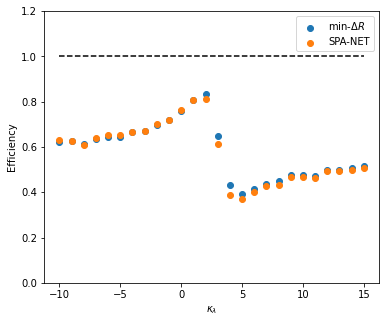

In [11]:
x = np.array(kappas)
min_dR_eff = [results['correct pair'] / results['Matching'] for results in min_dR_pairings]
SPANET_eff = [results['correct pair'] / results['Matching'] for results in SPANET_pairings]

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.plot(x, np.ones_like(x), 'k--')
ax.scatter(x, min_dR_eff, label='min-$\Delta R$')
ax.scatter(x, SPANET_eff, label='SPA-NET')
ax.legend()
ax.set_ylim(0,1.2)
ax.set_xlabel('$\kappa_\lambda$')
ax.set_ylabel('Efficiency')
ax.set_title('')

plt.savefig('figures/pairing_efficiency_kappa.png', facecolor='White', dpi=300, bbox_inches = 'tight')

plt.show()

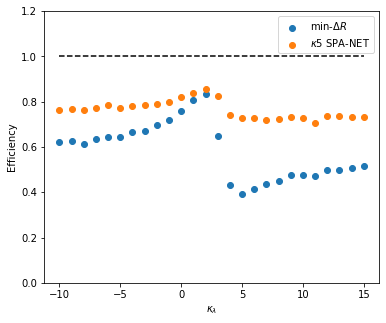

In [12]:
x = np.array(kappas)
min_dR_eff = [results['correct pair'] / results['Matching'] for results in min_dR_pairings]
SPANET_eff = [results['correct pair'] / results['Matching'] for results in k5_SPANET_pairings]

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.plot(x, np.ones_like(x), 'k--')
ax.scatter(x, min_dR_eff, label='min-$\Delta R$')
ax.scatter(x, SPANET_eff, label='$\kappa 5$ SPA-NET')
ax.legend()
ax.set_ylim(0,1.2)
ax.set_xlabel('$\kappa_\lambda$')
ax.set_ylabel('Efficiency')
ax.set_title('')

plt.savefig('figures/pairing_efficiency_kappa-k5.png', facecolor='White',dpi=300, bbox_inches = 'tight')

plt.show()